In [2]:
import codecs, re, os

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, roc_auc_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from imblearn.pipeline import make_pipeline as make_imb_pipeline
from sklearn.model_selection import cross_validate


In [3]:
def load_speaker(path="../data/raw/corpus.tache1.learn.utf8"):
    corpus = []
    classes = []
    f = codecs.open(path, "r", "utf-8")  # pour régler le codage
    while True:
        texte = f.readline()
        if (len(texte)) < 5:
            break
        label = re.sub(r"<\d*:\d*:(.)>.*", "\\1", texte)
        texte = re.sub(r"<\d*:\d*:.>(.*)", "\\1", texte)
        if label.count("M") > 0:
            classes.append(-1)
        else:
            classes.append(1)
        corpus.append(texte)
    return np.array(corpus), np.array(classes)


X, y = load_speaker()
X_train, X_test, y_train, y_test = train_test_split(X, y)


In [3]:
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import PrecisionRecallDisplay


def make_pipeline(mode, model):
    if mode == "original":
        return make_imb_pipeline(CountVectorizer(), model())
    elif mode == "oversampling":
        return make_imb_pipeline(CountVectorizer(), RandomOverSampler(), model())
    elif mode == "undersampling":
        return make_imb_pipeline(
            CountVectorizer(), RandomUnderSampler(replacement=False), model()
        )
    elif mode == "regularization" and model.__name__ != "MultinomialNB":
        return make_imb_pipeline(CountVectorizer(), model(class_weight="balanced"))
    elif "regularization" in mode and model.__name__ == "MultinomialNB":
        return make_imb_pipeline(CountVectorizer(), model(fit_prior=True))
    # elif mode == "balanced + regularization" and model.__name__ != "MultinomialNB":
    #     return make_imb_pipeline(CountVectorizer(), model(C=10))
    # elif mode == "balanced + regularization" and model.__name__ == "MultinomialNB":
    #     return make_imb_pipeline(CountVectorizer(), model(fit_prior=True, alpha=0.5))
    # elif mode == "balanced ++" and model.__name__ != "MultinomialNB":
    #     weights = {-1: 100000000, 1:1}
    #     return make_imb_pipeline(CountVectorizer(), model(class_weight=weights))


## Combien de $k$ pour la cross-validation ?


In [26]:
from tqdm import tqdm
from time import time
from sklearn.model_selection import StratifiedKFold, LeaveOneOut, cross_val_score

pipeline = make_pipeline("original", LogisticRegression)

# ideal = np.mean(cross_val_score(pipeline, X, y, scoring='accuracy', cv=LeaveOneOut(), n_jobs=-1))
# define folds to test
folds = range(2, 31)
# record mean and min/max of each set of results
means, mins, maxs, times = list(), list(), list(), list()
# evaluate each k value
for k in tqdm(folds):
    # define the test condition
    t = time()
    cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=1)
    # evaluate k value
    scores = cross_val_score(pipeline, X, y, scoring="roc_auc", cv=cv, n_jobs=-1)
    times.append(time() - t)
    k_mean, k_min, k_max = np.mean(scores), scores.min(), scores.max()
    # report performance
    print("> folds=%d, accuracy=%.3f (%.3f,%.3f)" % (k, k_mean, k_min, k_max))
    # store mean accuracy
    means.append(k_mean)
    # store min and max relative to the mean
    mins.append(k_mean - k_min)
    maxs.append(k_max - k_mean)


  3%|▎         | 1/29 [00:03<01:27,  3.12s/it]

> folds=2, accuracy=0.860 (0.858,0.863)


  7%|▋         | 2/29 [00:07<01:41,  3.75s/it]

> folds=3, accuracy=0.867 (0.865,0.869)


 10%|█         | 3/29 [00:12<01:59,  4.58s/it]

> folds=4, accuracy=0.871 (0.866,0.874)


 14%|█▍        | 4/29 [00:17<01:59,  4.78s/it]

> folds=5, accuracy=0.872 (0.867,0.875)


 17%|█▋        | 5/29 [00:24<02:12,  5.52s/it]

> folds=6, accuracy=0.873 (0.871,0.878)


 21%|██        | 6/29 [00:33<02:31,  6.58s/it]

> folds=7, accuracy=0.875 (0.869,0.887)


 24%|██▍       | 7/29 [00:41<02:36,  7.10s/it]

> folds=8, accuracy=0.875 (0.865,0.881)


 28%|██▊       | 8/29 [00:52<02:52,  8.21s/it]

> folds=9, accuracy=0.875 (0.867,0.887)


 31%|███       | 9/29 [01:03<03:02,  9.13s/it]

> folds=10, accuracy=0.876 (0.860,0.884)


 34%|███▍      | 10/29 [01:16<03:16, 10.37s/it]

> folds=11, accuracy=0.875 (0.869,0.880)


 38%|███▊      | 11/29 [01:30<03:28, 11.58s/it]

> folds=12, accuracy=0.876 (0.865,0.895)


 41%|████▏     | 12/29 [01:46<03:35, 12.68s/it]

> folds=13, accuracy=0.876 (0.856,0.888)


 45%|████▍     | 13/29 [02:01<03:37, 13.59s/it]

> folds=14, accuracy=0.876 (0.861,0.895)


 48%|████▊     | 14/29 [02:17<03:35, 14.35s/it]

> folds=15, accuracy=0.877 (0.862,0.892)


 52%|█████▏    | 15/29 [02:33<03:25, 14.64s/it]

> folds=16, accuracy=0.876 (0.857,0.888)


 55%|█████▌    | 16/29 [02:50<03:19, 15.37s/it]

> folds=17, accuracy=0.876 (0.847,0.900)


 59%|█████▊    | 17/29 [03:08<03:14, 16.25s/it]

> folds=18, accuracy=0.876 (0.861,0.888)


 62%|██████▏   | 18/29 [03:29<03:13, 17.56s/it]

> folds=19, accuracy=0.877 (0.856,0.906)


 66%|██████▌   | 19/29 [03:49<03:03, 18.34s/it]

> folds=20, accuracy=0.877 (0.855,0.895)


 69%|██████▉   | 20/29 [04:09<02:49, 18.79s/it]

> folds=21, accuracy=0.877 (0.852,0.900)


 72%|███████▏  | 21/29 [04:32<02:41, 20.19s/it]

> folds=22, accuracy=0.877 (0.856,0.896)


 76%|███████▌  | 22/29 [04:56<02:28, 21.28s/it]

> folds=23, accuracy=0.877 (0.852,0.894)


 79%|███████▉  | 23/29 [05:21<02:14, 22.42s/it]

> folds=24, accuracy=0.877 (0.856,0.903)


 83%|████████▎ | 24/29 [05:48<01:59, 23.89s/it]

> folds=25, accuracy=0.877 (0.855,0.895)


 86%|████████▌ | 25/29 [06:12<01:35, 23.86s/it]

> folds=26, accuracy=0.877 (0.851,0.908)


 90%|████████▉ | 26/29 [06:38<01:13, 24.39s/it]

> folds=27, accuracy=0.877 (0.849,0.900)


 93%|█████████▎| 27/29 [07:05<00:50, 25.30s/it]

> folds=28, accuracy=0.877 (0.853,0.902)


 97%|█████████▋| 28/29 [07:34<00:26, 26.24s/it]

> folds=29, accuracy=0.877 (0.853,0.907)


100%|██████████| 29/29 [08:02<00:00, 16.64s/it]

> folds=30, accuracy=0.877 (0.846,0.900)


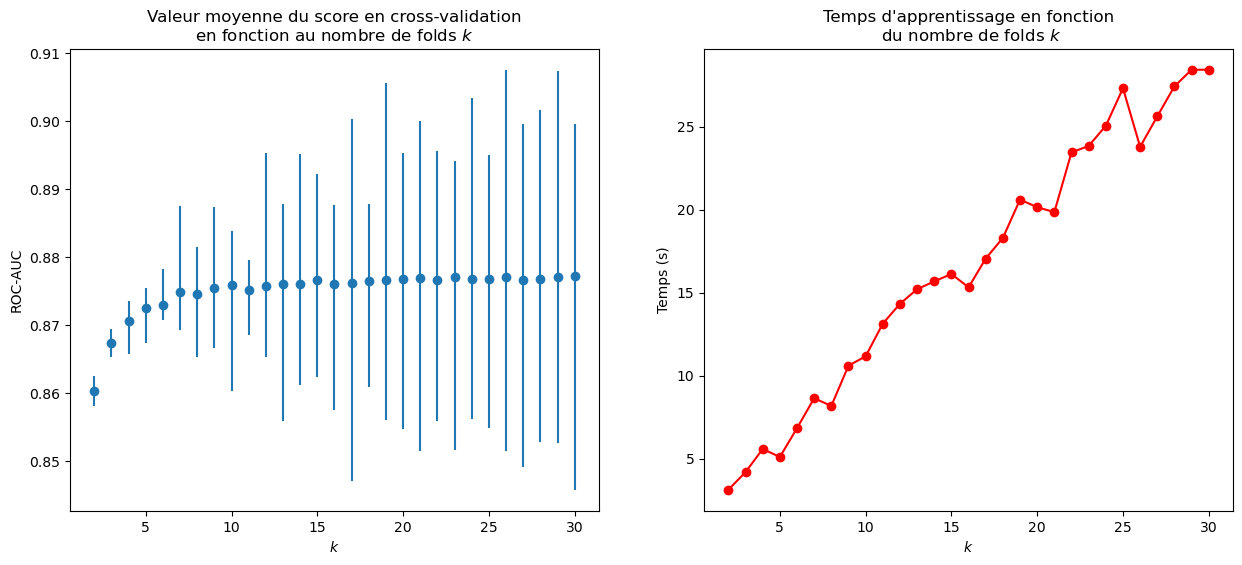

In [37]:
# line plot of k mean values with min/max error bars
plt.figure(figsize=(15, 6))
plt.subplot(121)
plt.errorbar(folds, means, yerr=[mins, maxs], fmt="o")
plt.xlabel("$k$")
plt.ylabel("ROC-AUC")
plt.title(
    "Valeur moyenne du score en cross-validation\nen fonction au nombre de folds $k$"
)
plt.subplot(122)
plt.plot(folds, times, "ro-")
plt.xlabel("$k$")
plt.ylabel("Temps (s)")
plt.title("Temps d'apprentissage en fonction\n du nombre de folds $k$")
# plot the ideal case in a separate color
# plt.plot(folds, [ideal for _ in range(len(folds))], color='r')
# show the plot
plt.savefig("../reports/figures/crossval_analysis.png", dpi=100, bbox_inches="tight")
plt.show()


## Temps d'apprentissage en fonction du vocabulaire


In [5]:
from time import time

vectorizer = CountVectorizer(ngram_range=(1, 3))
_ = vectorizer.fit_transform(X_train)
s = len(vectorizer.vocabulary_)
print("taille du vocabulaire : ", s)

times = {"nb": [], "lr": [], "svm": []}
for features in range(10000, s, 10000):
    vectorizer = CountVectorizer(ngram_range=(2, 2), max_features=features)
    X_train_2 = vectorizer.fit_transform(X_train)
    t0 = time()
    nb_clf = MultinomialNB()
    nb_clf.fit(X_train_2, y_train)
    times["nb"].append(time() - t0)
    t0 = time()
    nb_clf = LogisticRegression(max_iter=10000)
    nb_clf.fit(X_train_2, y_train)
    times["lr"].append(time() - t0)
    t0 = time()
    nb_clf = LinearSVC(max_iter=10000)
    nb_clf.fit(X_train_2, y_train)
    times["svm"].append(time() - t0)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.plot(range(10000, s, 10000), times["nb"], label="Naive Bayes")
plt.plot(range(10000, s, 10000), times["lr"], label="LogReg")
plt.plot(range(10000, s, 10000), times["svm"], label="SVM")
plt.legend()
plt.xlabel("Taille du vocabulaire")
plt.ylabel("Temps d'apprentissage du classifier")
plt.title(
    "Temps d'apprentissage d'un classifieur en fonction de la taille du vocabulaire"
)
plt.savefig(
    "../reports/figures/complexity_analysis_vocabulary.png",
    dpi=100,
    bbox_inches="tight",
)
plt.show()


taille du vocabulaire :  837233


## Learning Curves


### Présidents


Sur les modèles bruts (sans avoir touché aux paramètres) :


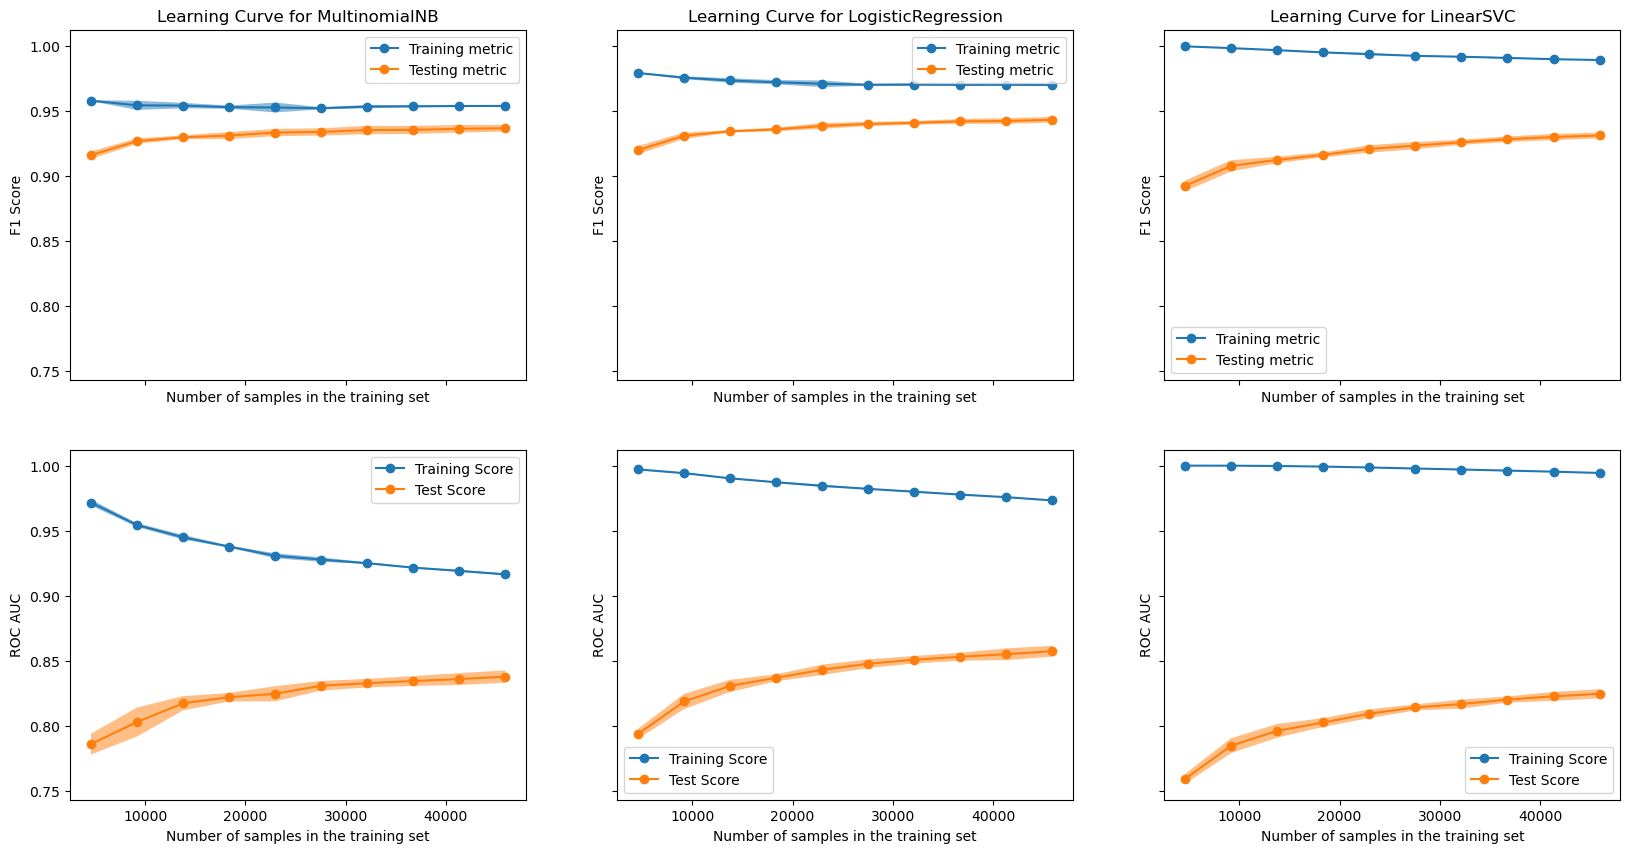

In [4]:
from sklearn.model_selection import LearningCurveDisplay, ShuffleSplit

common_params_roc = {
    "X": X,
    "y": y,
    "train_sizes": np.linspace(0.1, 1.0, 10),
    "cv": 5,
    "score_type": "both",
    "n_jobs": -1,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "scoring": "roc_auc",
    "score_name": "ROC AUC",
}

common_params_f1 = {
    "X": X,
    "y": y,
    "train_sizes": np.linspace(0.1, 1.0, 10),
    "cv": 5,
    "score_type": "both",
    "n_jobs": -1,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "scoring": "f1",
    "score_name": "F1 Score",
}

models = [MultinomialNB, LogisticRegression, LinearSVC]

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20, 10), sharex=True, sharey=True)

for ax_idx, model in enumerate(models):
    pipeline = make_pipeline("original", model)
    LearningCurveDisplay.from_estimator(pipeline, **common_params_f1, ax=ax[0, ax_idx])
    LearningCurveDisplay.from_estimator(pipeline, **common_params_roc, ax=ax[1, ax_idx])
    handles, label = ax[0, ax_idx].get_legend_handles_labels()
    ax[1, ax_idx].legend(handles[:2], ["Training Score", "Test Score"])
    ax[0, ax_idx].set_title(f"Learning Curve for {model.__name__}")
plt.savefig("../reports/figures/learningcurve.png", dpi=100, bbox_inches="tight")


Après avoir optimisé les paramètres :


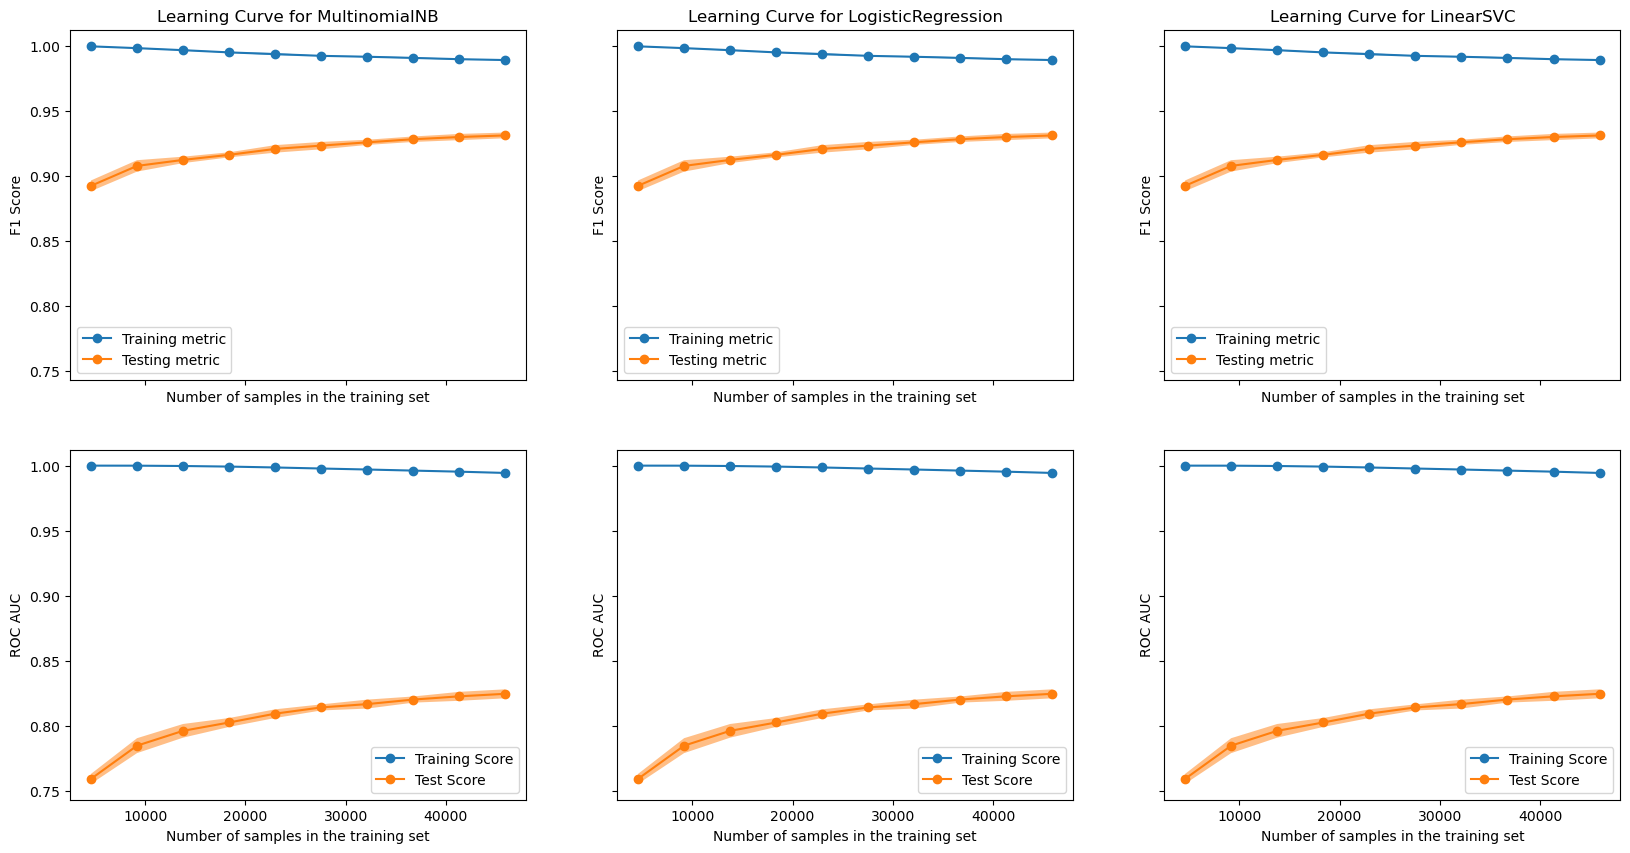

In [5]:
import joblib

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20, 10), sharex=True, sharey=True)

for ax_idx, model in enumerate(models):
    d = joblib.load(f"../gridsearch/results/part1_hrscv_{model.__name__}.pkl")
    LearningCurveDisplay.from_estimator(pipeline, **common_params_f1, ax=ax[0, ax_idx])
    LearningCurveDisplay.from_estimator(pipeline, **common_params_roc, ax=ax[1, ax_idx])
    handles, label = ax[0, ax_idx].get_legend_handles_labels()
    ax[1, ax_idx].legend(handles[:2], ["Training Score", "Test Score"])
    ax[0, ax_idx].set_title(f"Learning Curve for {model.__name__}")
plt.savefig("../reports/figures/learningcurve_opti.png", dpi=100, bbox_inches="tight")


## Complexity analysis


In [6]:
from sklearn.model_selection import learning_curve

common_params = {
    "X": X,
    "y": y,
    "train_sizes": np.linspace(0.1, 1.0, 10),
    "cv": 5,
    "n_jobs": 6,
    "return_times": True,
    "scoring": "f1",
}

naive_bayes = make_pipeline("original", MultinomialNB)
lr = make_pipeline("original", LogisticRegression)
svc = make_pipeline("original", LinearSVC)

train_sizes, _, test_scores_nb, fit_times_nb, score_times_nb = learning_curve(
    naive_bayes, **common_params
)

train_sizes, _, test_scores_lr, fit_times_lr, score_times_lr = learning_curve(
    lr, **common_params
)
train_sizes, _, test_scores_svm, fit_times_svm, score_times_svm = learning_curve(
    svc, **common_params
)


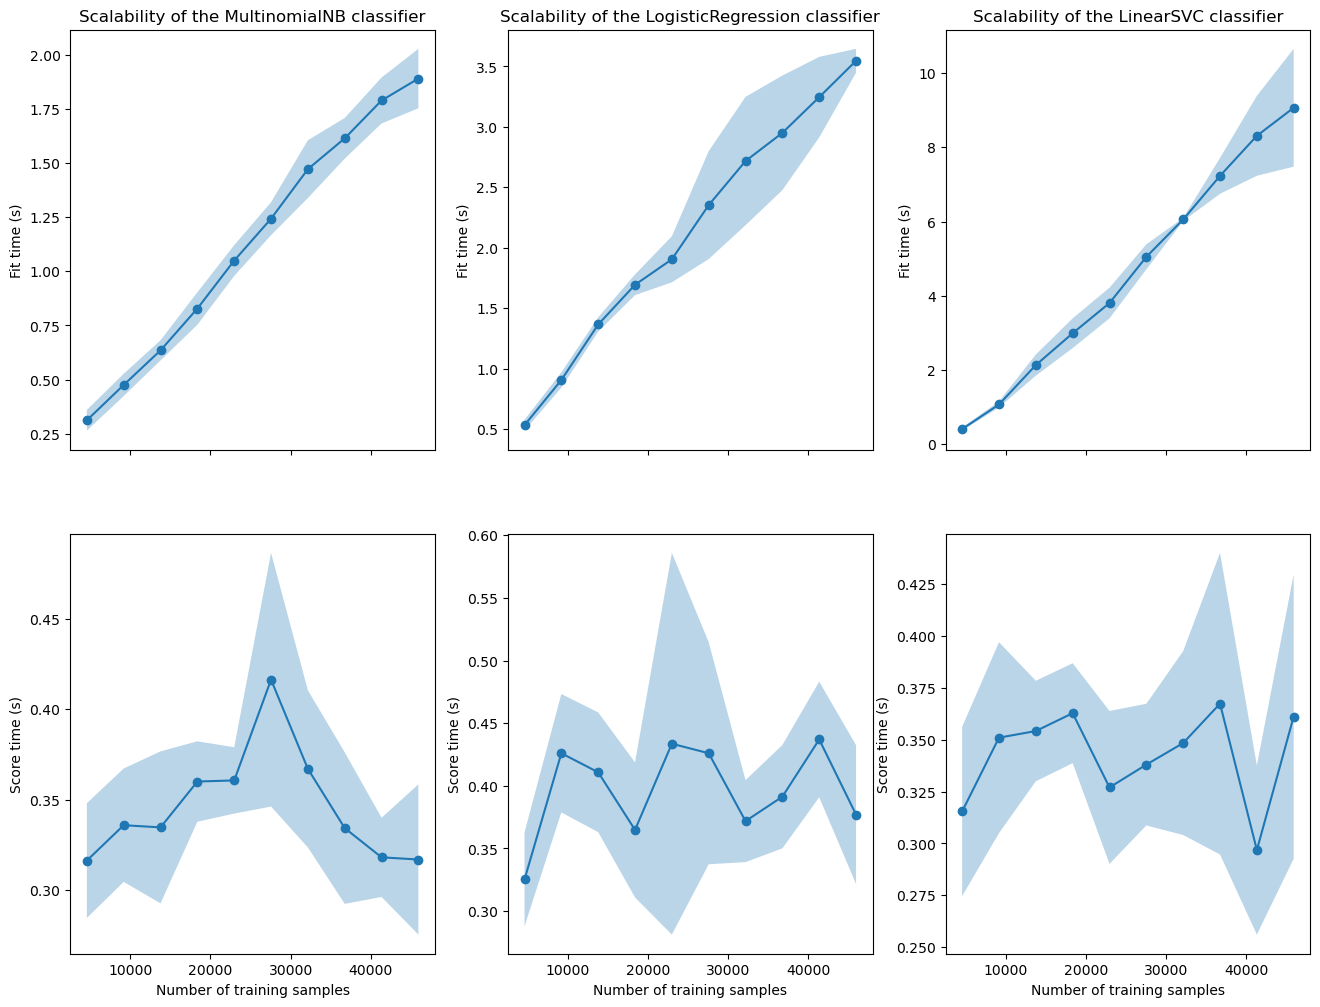

In [7]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(16, 12), sharex=True)


for ax_idx, (fit_times, score_times, estimator) in enumerate(
    zip(
        [fit_times_nb, fit_times_lr, fit_times_svm],
        [score_times_nb, score_times_lr, score_times_svm],
        ["MultinomialNB", "LogisticRegression", "LinearSVC"],
    )
):
    # scalability regarding the fit time
    ax[0, ax_idx].plot(train_sizes, fit_times.mean(axis=1), "o-")
    ax[0, ax_idx].fill_between(
        train_sizes,
        fit_times.mean(axis=1) - fit_times.std(axis=1),
        fit_times.mean(axis=1) + fit_times.std(axis=1),
        alpha=0.3,
    )
    ax[0, ax_idx].set_ylabel("Fit time (s)")
    ax[0, ax_idx].set_title(f"Scalability of the {estimator} classifier")

    # scalability regarding the score time
    ax[1, ax_idx].plot(train_sizes, score_times.mean(axis=1), "o-")
    ax[1, ax_idx].fill_between(
        train_sizes,
        score_times.mean(axis=1) - score_times.std(axis=1),
        score_times.mean(axis=1) + score_times.std(axis=1),
        alpha=0.3,
    )
    ax[1, ax_idx].set_ylabel("Score time (s)")
    ax[1, ax_idx].set_xlabel("Number of training samples")

plt.savefig(
    "../reports/figures/complexity_analysis_nsamples.png", dpi=100, bbox_inches="tight"
)


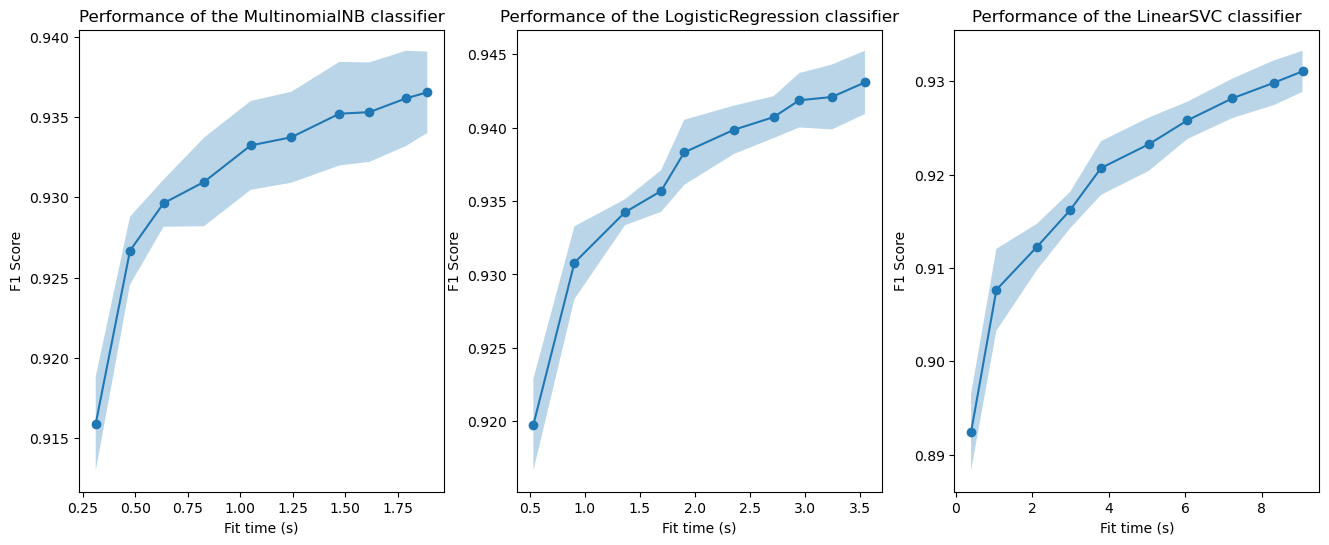

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 6))

for ax_idx, (fit_times, test_scores, estimator) in enumerate(
    zip(
        [fit_times_nb, fit_times_lr, fit_times_svm],
        [test_scores_nb, test_scores_lr, test_scores_svm],
        ["MultinomialNB", "LogisticRegression", "LinearSVC"],
    )
):
    ax[ax_idx].plot(fit_times.mean(axis=1), test_scores.mean(axis=1), "o-")
    ax[ax_idx].fill_between(
        fit_times.mean(axis=1),
        test_scores.mean(axis=1) - test_scores.std(axis=1),
        test_scores.mean(axis=1) + test_scores.std(axis=1),
        alpha=0.3,
    )
    ax[ax_idx].set_ylabel("F1 Score")
    ax[ax_idx].set_xlabel("Fit time (s)")
    ax[ax_idx].set_title(f"Performance of the {estimator} classifier")

plt.savefig(
    "../reports/figures/complexity_analysis_accuracy.png", dpi=100, bbox_inches="tight"
)
plt.show()


## ROC-AUC Curves


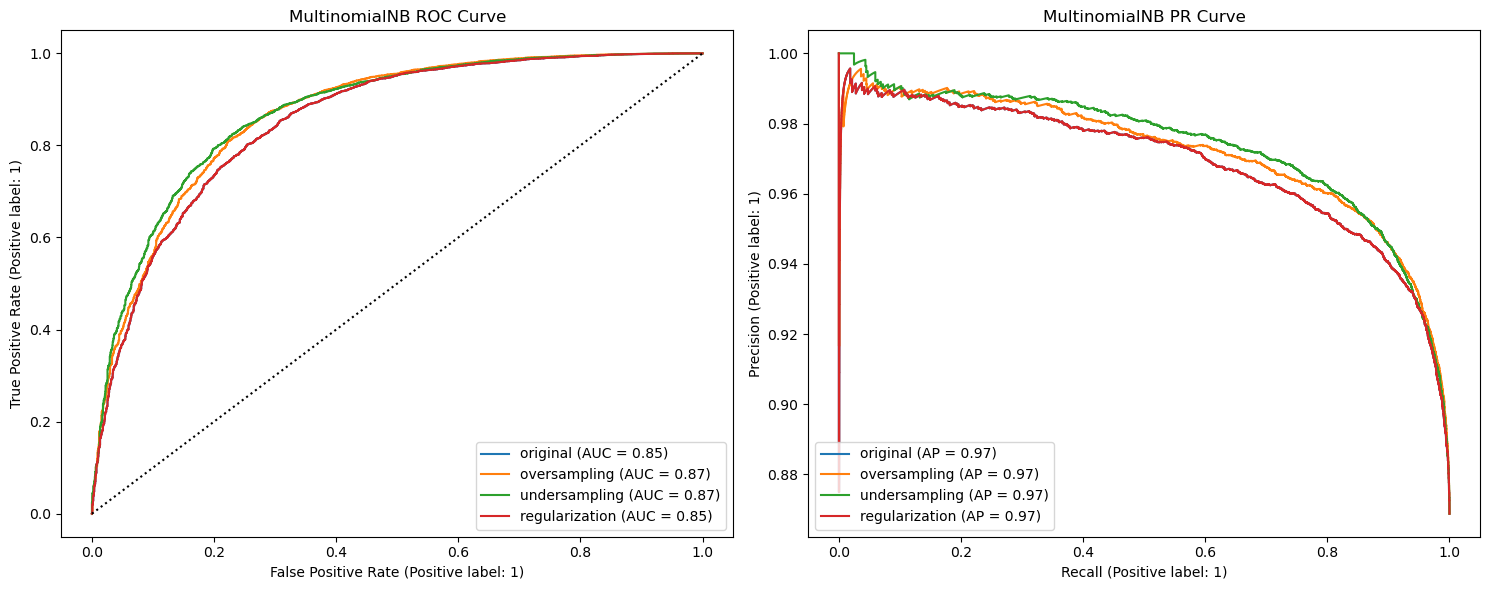

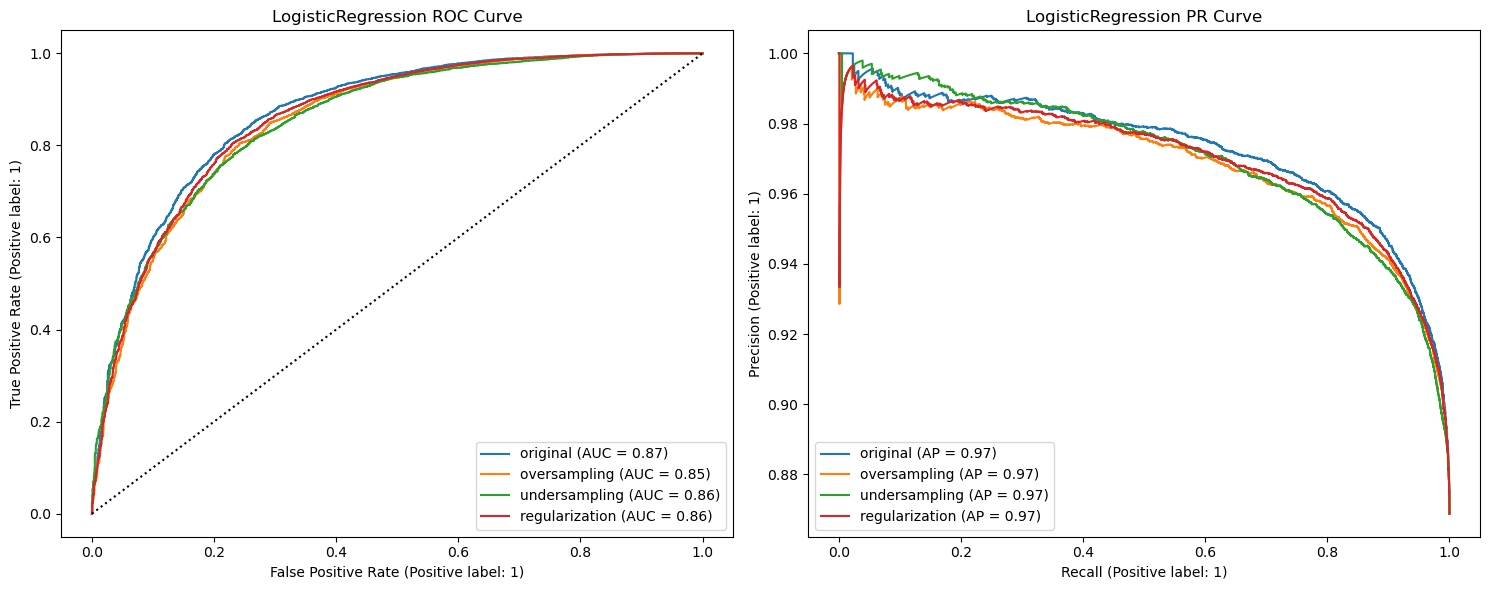

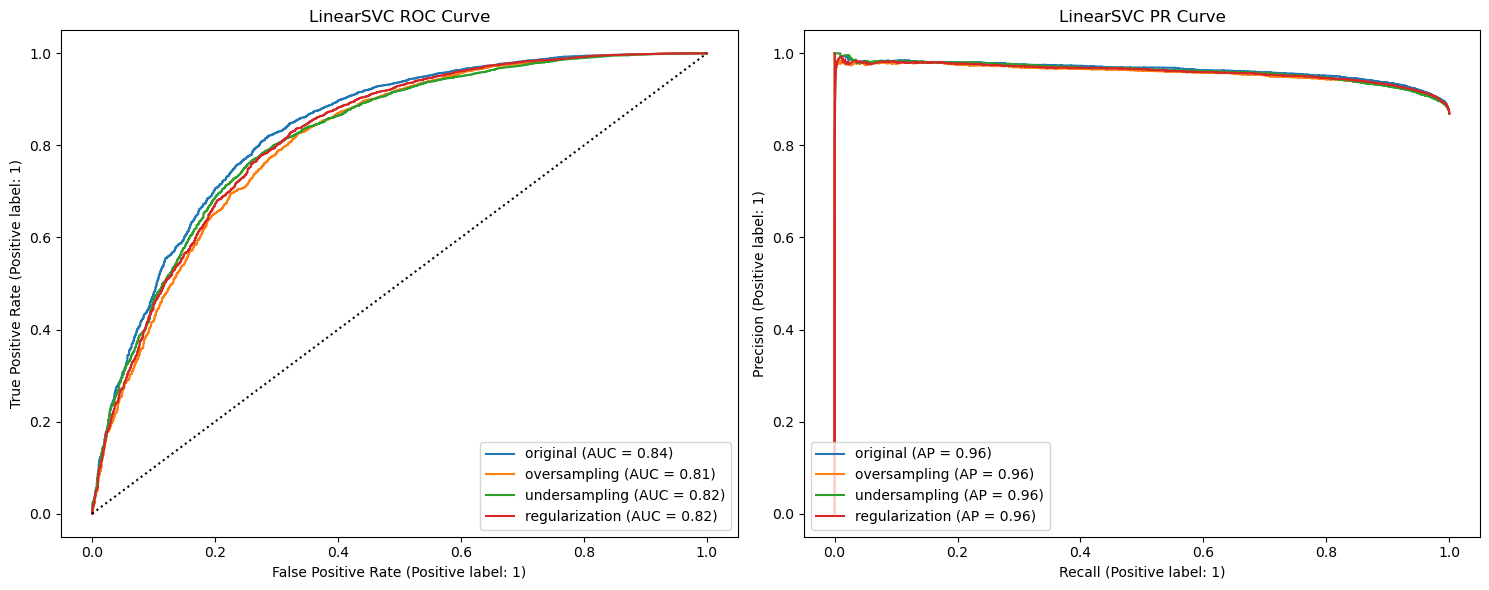

In [9]:
models = [MultinomialNB, LogisticRegression, LinearSVC]

sampler = ["original", "oversampling", "undersampling", "regularization"]

for i, model in enumerate(models):
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))
    for sample in sampler:
        pipeline = make_pipeline(sample, model)
        pipeline.fit(X_train, y_train)
        RocCurveDisplay.from_estimator(pipeline, X_test, y_test, name=sample, ax=ax[0])
        PrecisionRecallDisplay.from_estimator(
            pipeline, X_test, y_test, name=sample, ax=ax[1]
        )
    ax[0].set_title(f"{model.__name__} ROC Curve")
    ax[0].plot([0, 1], [0, 1], "k:", label="(AUC = 0.5)")
    ax[1].set_title(f"{model.__name__} PR Curve")
    plt.tight_layout()
    plt.savefig(
        f"../reports/figures/roc_curve_{model.__name__}.png",
        dpi=100,
        bbox_inches="tight",
    )
    plt.show()


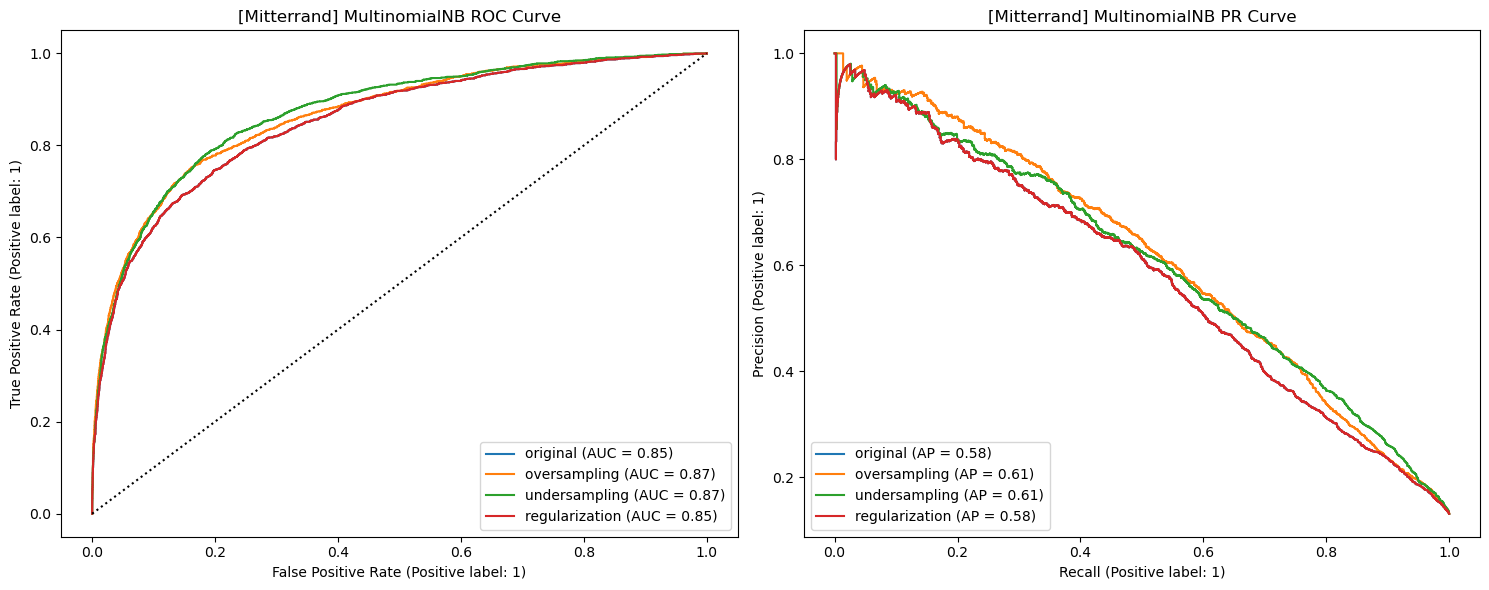

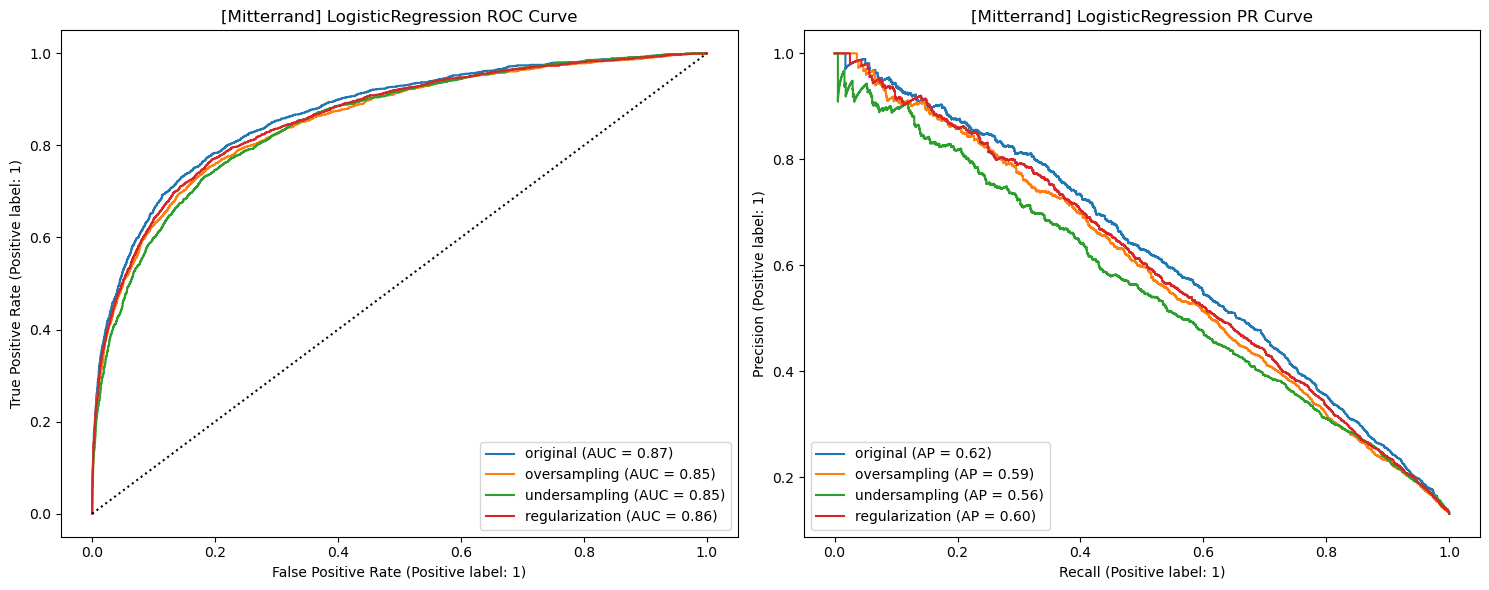

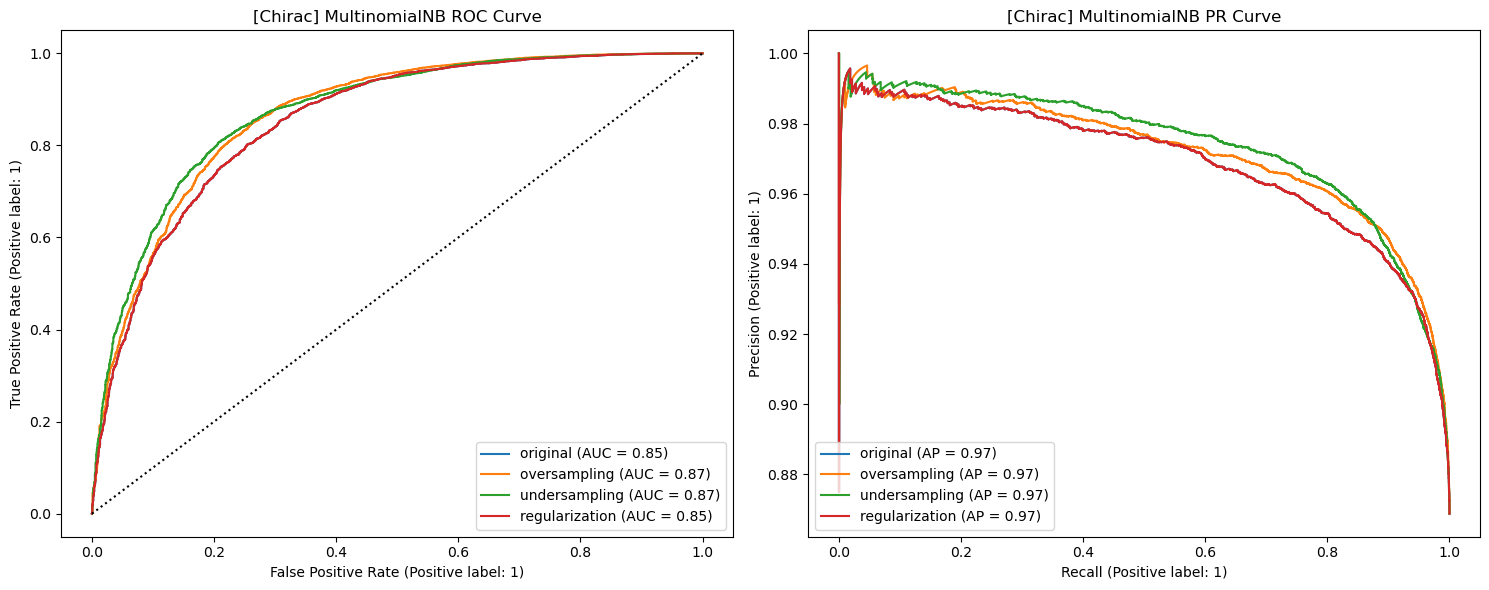

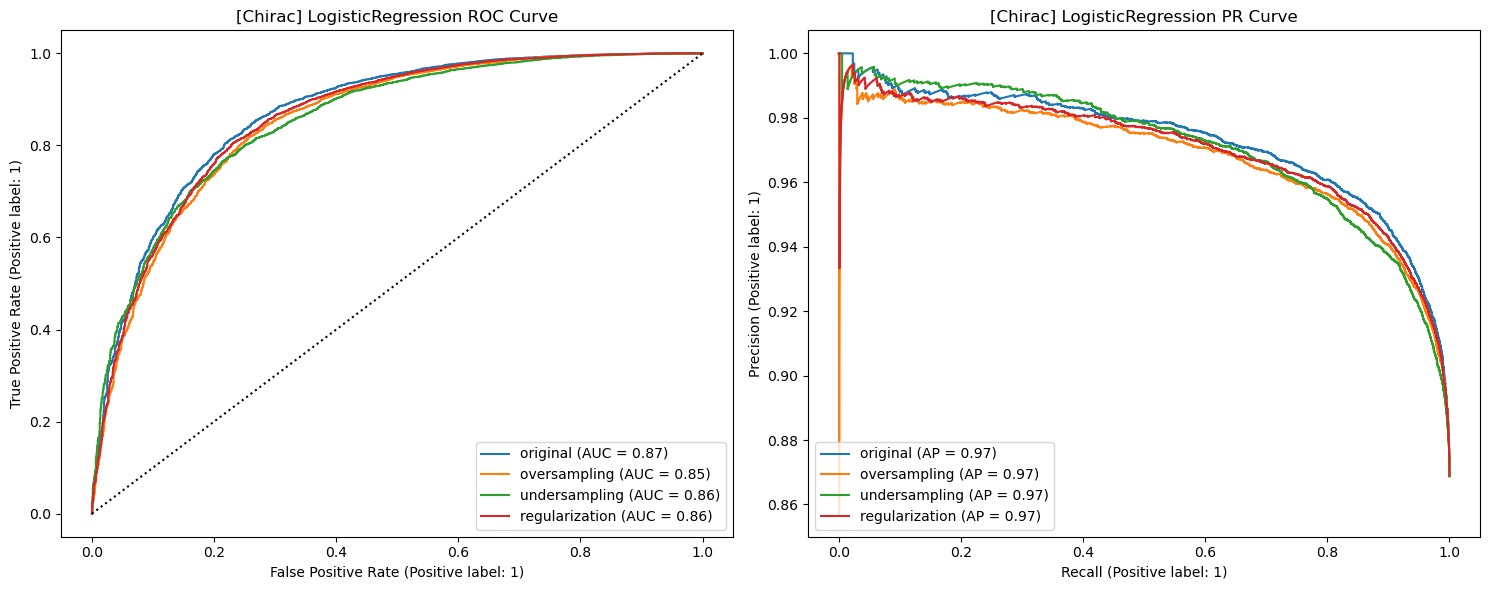

In [10]:
y_onehot_test = pd.get_dummies(y_test).to_numpy()

sampler = ["original", "oversampling", "undersampling", "regularization"]
models = [MultinomialNB, LogisticRegression]


classes = ["Mitterrand", "Chirac"]
for class_id, class_name in enumerate(classes):

    for i, model in enumerate(models):
        fig, ax = plt.subplots(1, 2, figsize=(15, 6))
        for sample in sampler:
            pipeline = make_pipeline(sample, model)
            pipeline.fit(X_train, y_train)
            y_pred = pipeline.predict_proba(X_test)
            RocCurveDisplay.from_predictions(
                y_onehot_test[:, class_id],
                y_pred[:, class_id],
                name=f"{sample}",
                ax=ax[0],
            )
            PrecisionRecallDisplay.from_predictions(
                y_onehot_test[:, class_id],
                y_pred[:, class_id],
                name=f"{sample}",
                ax=ax[1],
            )
        ax[0].set_title(f"[{class_name}] {model.__name__} ROC Curve")
        ax[0].plot([0, 1], [0, 1], "k:", label="(AUC = 0.5)")
        ax[1].set_title(f"[{class_name}] {model.__name__} PR Curve")
        plt.tight_layout()
        plt.savefig(
            f"../reports/figures/roc_curve_{model.__name__}_{class_name}.png",
            dpi=100,
            bbox_inches="tight",
        )
        plt.show()


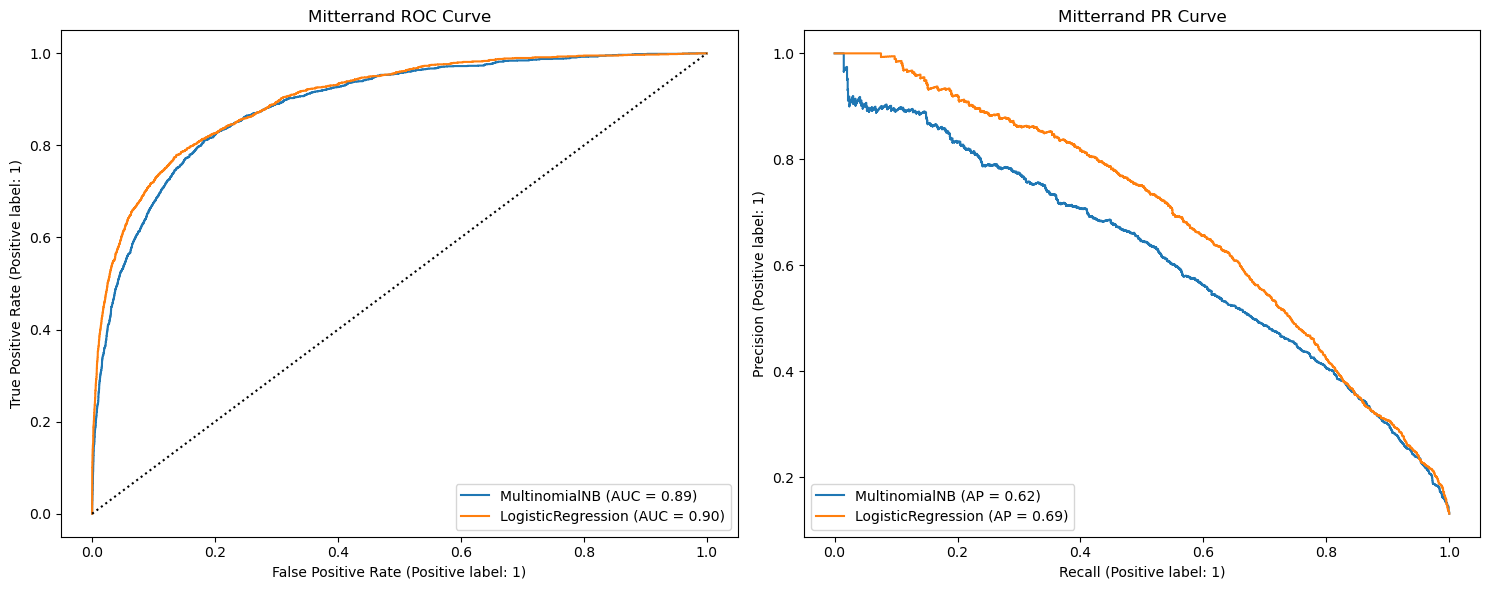

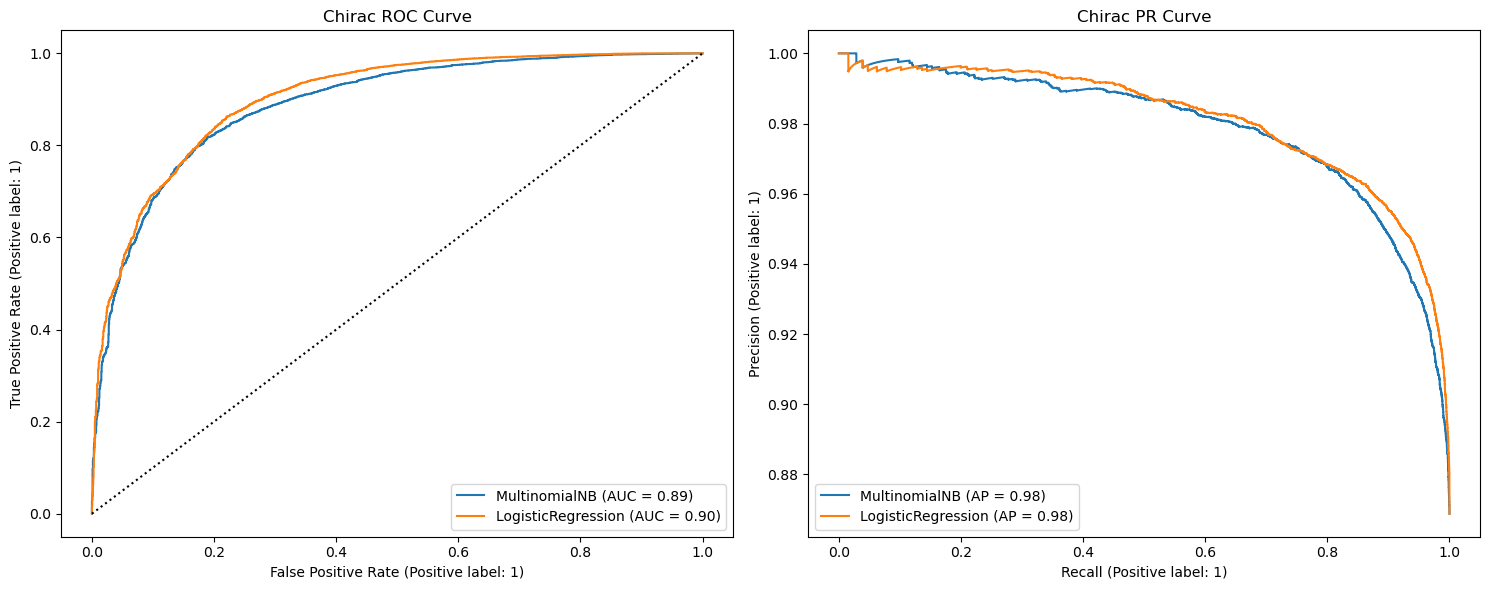

In [11]:
import joblib

y_onehot_test = pd.get_dummies(y_test).to_numpy()

models = ["MultinomialNB", "LogisticRegression"]


classes = ["Mitterrand", "Chirac"]
for class_id, class_name in enumerate(classes):
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))
    for i, model in enumerate(models):
        pipeline = joblib.load(
            f"../gridsearch/results/part1_hrscv_{model}_mcc.pkl"
        ).best_estimator_
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict_proba(X_test)
        RocCurveDisplay.from_predictions(
            y_onehot_test[:, class_id], y_pred[:, class_id], name=f"{model}", ax=ax[0]
        )
        PrecisionRecallDisplay.from_predictions(
            y_onehot_test[:, class_id], y_pred[:, class_id], name=f"{model}", ax=ax[1]
        )
    ax[0].set_title(f"{class_name} ROC Curve")
    ax[0].plot([0, 1], [0, 1], "k:", label="(AUC = 0.5)")
    ax[1].set_title(f"{class_name} PR Curve")
    plt.tight_layout()
    plt.savefig(
        f"../reports/figures/roc_curve_{model}_{class_name}.png",
        dpi=100,
        bbox_inches="tight",
    )
    plt.show()


## Les blocs !!!!


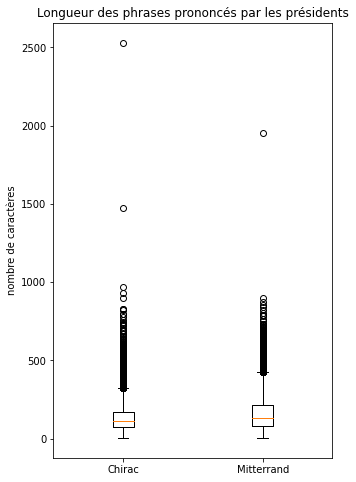

In [4]:
import seaborn as sns

my_dict = {
    "Chirac": [len(phrases) for phrases in X[y == 1]],
    "Mitterrand": [len(phrases) for phrases in X[y == -1]],
}

fig, ax = plt.subplots(figsize=(5, 8))
ax.boxplot(my_dict.values())
ax.set_xticklabels(my_dict.keys())
ax.set_ylabel("nombre de caractères")
plt.title("Longueur des phrases prononcés par les présidents")
plt.savefig("../reports/figures/boxplot_phrases.png", dpi=100, bbox_inches="tight")


In [5]:
pd.DataFrame(my_dict["Chirac"]).describe()


,0
count,49890.000000
mean,132.248968
std,82.298427
min,4.000000
25%,73.000000
50%,116.000000
75%,173.000000
max,2530.000000


In [6]:
pd.DataFrame(my_dict["Mitterrand"]).describe()


,0
count,7523.000000
mean,164.231822
std,120.202628
min,7.000000
25%,78.000000
50%,135.000000
75%,217.500000
max,1951.000000


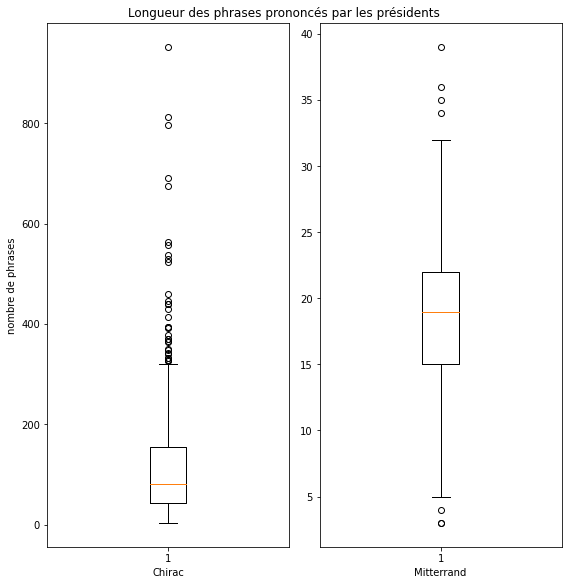

In [7]:
def nested_blocks(arr):
    blocks = []
    curr_block = []
    prev_val = None

    for val in arr:
        if val != prev_val:
            if curr_block:
                blocks.append(np.array(curr_block))
                curr_block = []
        curr_block.append(val)
        prev_val = val

    if curr_block:
        blocks.append(np.array(curr_block))

    return blocks


y_nested = nested_blocks(y)
my_dict = {
    "Chirac": [len(block) for block in y_nested if np.all(block == 1)],
    "Mitterrand": [len(block) for block in y_nested if np.all(block == -1)],
}

fig, ax = plt.subplots(1, 2, figsize=(8, 8))
ax[0].boxplot(my_dict["Chirac"])
ax[0].set_xlabel("Chirac")
ax[0].set_ylabel("nombre de phrases")
ax[1].boxplot(my_dict["Mitterrand"])
ax[1].set_xlabel("Mitterrand")
plt.tight_layout()
plt.suptitle("Longueur des phrases prononcés par les présidents", y=1.01)
plt.savefig("../reports/figures/boxplot_discours.png", dpi=100, bbox_inches="tight")


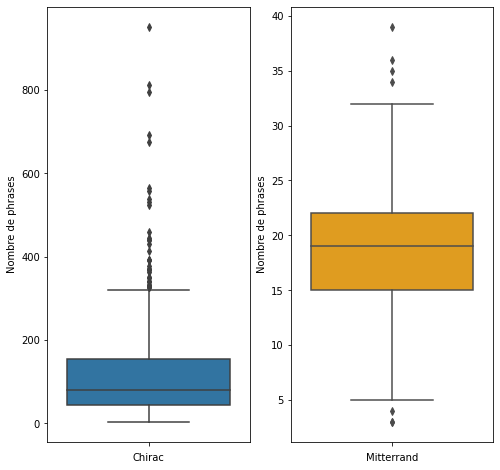

In [29]:
longueur_list, president_list = [], []
for length in my_dict["Chirac"]:
    longueur_list.append(length)
df_chirac = pd.DataFrame(
    {
        "Nombre de phrases": longueur_list,
    }
)

longueur_list, president_list = [], []
for length in my_dict["Mitterrand"]:
    longueur_list.append(length)
df_mit = pd.DataFrame(
    {
        "Nombre de phrases": longueur_list,
    }
)
fig, ax = plt.subplots(1, 2, figsize=(8, 8))
ax[0].set_xlabel("Chirac")
ax[1].set_xlabel("Mitterrand")
sns.boxplot(data=df_chirac, y="Nombre de phrases", ax=ax[0])
sns.boxplot(data=df_mit, y="Nombre de phrases", ax=ax[1], color="orange")
fig.savefig("../reports/figures/boxplot_discours.png", dpi=100, bbox_inches="tight")


In [23]:
df


,Nombre de phrases,Président
0,11,Chirac
1,27,Chirac
2,25,Chirac
3,40,Chirac
4,68,Chirac
...,...,...
796,22,Mitterrand
797,17,Mitterrand
798,22,Mitterrand
799,20,Mitterrand


In [42]:
pd.DataFrame(my_dict["Chirac"]).describe()


,0
count,401.000000
mean,124.413965
std,130.677516
min,3.000000
25%,43.000000
50%,80.000000
75%,154.000000
max,952.000000


In [44]:
pd.DataFrame(my_dict["Mitterrand"]).describe()


,0
count,400.000000
mean,18.807500
std,5.430854
min,3.000000
25%,15.000000
50%,19.000000
75%,22.000000
max,39.000000


In [14]:
def nested_blocks(X, y):
    blocks = []
    curr_block = []
    prev_val = None
    change_points = [0]  # list of indices where a new block starts

    # iterate over the labels
    for i, val in enumerate(y):
        if val != prev_val:
            # if the value changes, start a new block
            if curr_block:
                blocks.append(
                    curr_block
                )  # add the previous block to the list of blocks
                curr_block = []  # reset the current block
                change_points.append(
                    i
                )  # add the index of the new block to the change points
        curr_block.append(val)  # add the current value to the current block
        prev_val = val  # set the previous value to the current value

    if curr_block:
        blocks.append(curr_block)  # add the last block to the list of block
        change_points.append(
            len(y)
        )  # add the index of the end of the array to the change points

    discours = []
    for block in blocks:
        # find the start and end indices of the current block in the original array
        start = y.tolist().index(block[0], change_points[blocks.index(block)])
        end = y.tolist().index(block[-1], start) + 1
        end = min(
            end, len(y)
        )  # make sure end is not larger than the length of the array
        # use the change points to get the corresponding lines from the lines array,
        # and join them with spaces
        discours.append(
            " ".join(
                X[
                    change_points[blocks.index(block)] : change_points[
                        blocks.index(block) + 1
                    ]
                ]
            )
        )

    labels = [block[0] for block in blocks]

    assert len(discours) == len(labels)

    return discours, labels


X_nested, y_nested = nested_blocks(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_nested, y_nested)


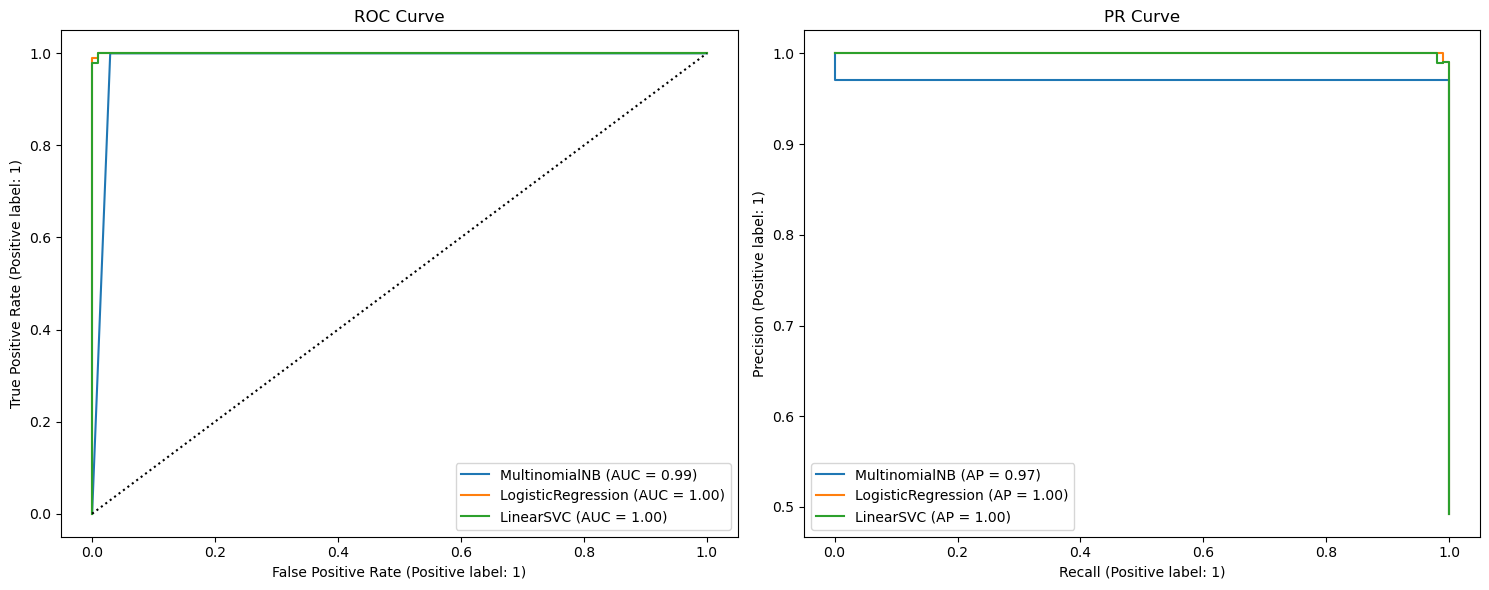

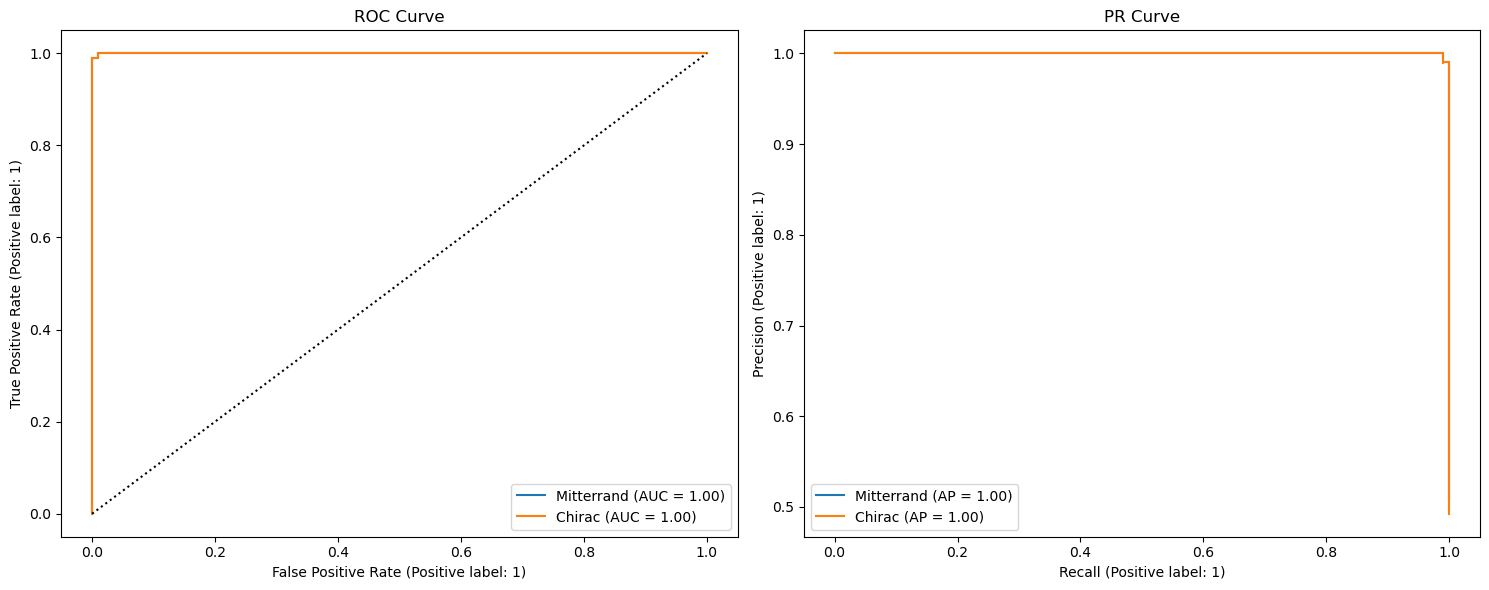

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_nested, y_nested)

fig, ax = plt.subplots(1, 2, figsize=(15, 6))

models = [MultinomialNB, LogisticRegression, LinearSVC]

for i, model in enumerate(models):
    pipeline = make_pipeline("original", model)
    pipeline.fit(X_train, y_train)
    RocCurveDisplay.from_estimator(
        pipeline, X_test, y_test, name=model.__name__, ax=ax[0]
    )
    PrecisionRecallDisplay.from_estimator(
        pipeline, X_test, y_test, name=model.__name__, ax=ax[1]
    )
ax[0].set_title(f"ROC Curve")
ax[0].plot([0, 1], [0, 1], "k:", label="(AUC = 0.5)")
ax[1].set_title(f"PR Curve")
plt.tight_layout()
plt.savefig("../reports/figures/roc_curve_blocks.png", dpi=100)
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(15, 6))
y_onehot_test = pd.get_dummies(y_test).to_numpy()

classes = ["Mitterrand", "Chirac"]
for class_id, class_name in enumerate(classes):
    pipeline = make_imb_pipeline(CountVectorizer(), LogisticRegression())
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict_proba(X_test)
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id], y_pred[:, class_id], name=f"{class_name}", ax=ax[0]
    )
    PrecisionRecallDisplay.from_predictions(
        y_onehot_test[:, class_id], y_pred[:, class_id], name=f"{class_name}", ax=ax[1]
    )
ax[0].set_title(f"ROC Curve")
ax[0].plot([0, 1], [0, 1], "k:", label="(AUC = 0.5)")
ax[1].set_title(f"PR Curve")
plt.tight_layout()
plt.savefig(
    "../reports/figures/roc_curve_blocks_classes.png", dpi=100, bbox_inches="tight"
)
plt.show()


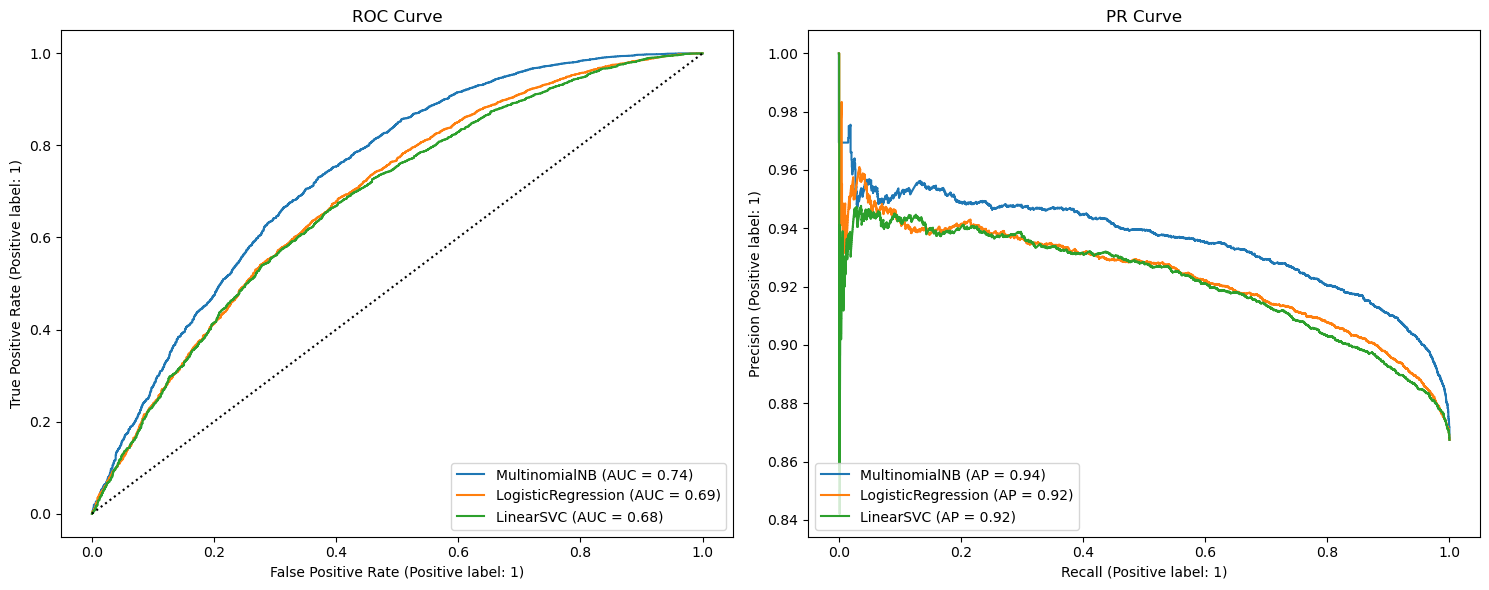

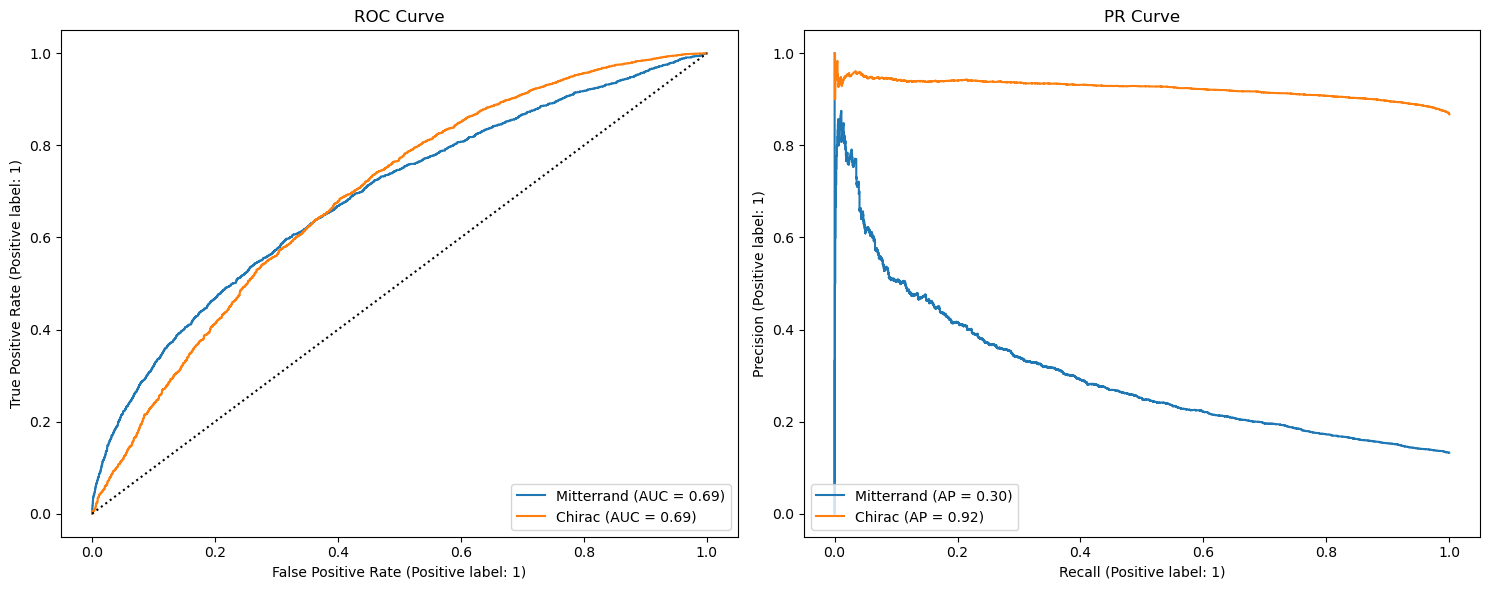

In [16]:
X, y = load_speaker()
_, X_test, _, y_test = train_test_split(X, y)
X_nested, y_nested = nested_blocks(X, y)
X_train, _, y_train, _ = train_test_split(X_nested, y_nested)

fig, ax = plt.subplots(1, 2, figsize=(15, 6))

models = [MultinomialNB, LogisticRegression, LinearSVC]

for i, model in enumerate(models):
    pipeline = make_pipeline("original", model)
    pipeline.fit(X_train, y_train)
    RocCurveDisplay.from_estimator(
        pipeline, X_test, y_test, name=model.__name__, ax=ax[0]
    )
    PrecisionRecallDisplay.from_estimator(
        pipeline, X_test, y_test, name=model.__name__, ax=ax[1]
    )
ax[0].set_title(f"ROC Curve")
ax[0].plot([0, 1], [0, 1], "k:", label="(AUC = 0.5)")
ax[1].set_title(f"PR Curve")
plt.tight_layout()
plt.savefig("../reports/figures/roc_curve_blocks2.png", dpi=100)
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(15, 6))
y_onehot_test = pd.get_dummies(y_test).to_numpy()

classes = ["Mitterrand", "Chirac"]
for class_id, class_name in enumerate(classes):
    pipeline = make_imb_pipeline(CountVectorizer(), LogisticRegression())
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict_proba(X_test)
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id], y_pred[:, class_id], name=f"{class_name}", ax=ax[0]
    )
    PrecisionRecallDisplay.from_predictions(
        y_onehot_test[:, class_id], y_pred[:, class_id], name=f"{class_name}", ax=ax[1]
    )
ax[0].set_title(f"ROC Curve")
ax[0].plot([0, 1], [0, 1], "k:", label="(AUC = 0.5)")
ax[1].set_title(f"PR Curve")
plt.tight_layout()
plt.savefig(
    "../reports/figures/roc_curve_blocks2_classes.png", dpi=100, bbox_inches="tight"
)
plt.show()
